In [1]:
folder_path = '/Users/priyankapalaniselvam/Downloads/a_new_dataset/cataract_data'


In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory



In [3]:
IMAGE_SIZE = (600, 600)  
BATCH_SIZE = 32

In [19]:
rescale = tf.keras.layers.Rescaling(1. / 255)

In [5]:
class_names = ['cataract', 'normal']


In [20]:
train_ds = image_dataset_from_directory(
    directory=folder_path,
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode='categorical',
    class_names=class_names
)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

validation_ds = image_dataset_from_directory(
    directory=folder_path,
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode='categorical',
    class_names=class_names
)
validation_ds = validation_ds.map(lambda x, y: (rescale(x), y))


Found 2112 files belonging to 2 classes.
Using 1690 files for training.
Found 2112 files belonging to 2 classes.
Using 422 files for validation.


In [21]:
test_ds = image_dataset_from_directory(
    directory=folder_path,
    batch_size=32,
    image_size=(256, 256),
    label_mode='categorical',
    class_names=class_names,
    shuffle=False
)
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

Found 2112 files belonging to 2 classes.


In [22]:
base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = False 

/var/folders/yz/41sd_4nd6x99n56sh17tm_lh0000gn/T/ipykernel_9875/921037605.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [23]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10
)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.8719 - loss: 0.2705 - val_accuracy: 0.9597 - val_loss: 0.1162
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9733 - loss: 0.0901 - val_accuracy: 0.9550 - val_loss: 0.1089
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9657 - loss: 0.0959 - val_accuracy: 0.9502 - val_loss: 0.1036
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9724 - loss: 0.0729 - val_accuracy: 0.9550 - val_loss: 0.0995
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9701 - loss: 0.0698 - val_accuracy: 0.9597 - val_loss: 0.1046
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9793 - loss: 0.0621 - val_accuracy: 0.9645 - val_loss: 0.0982
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9832 - loss: 0.0460 - val_accuracy: 0.9573 - val_loss: 0.0977
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9808 - loss: 0.0508 - val_accuracy: 0.9621 - val_los

In [25]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


66/66 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9684 - loss: 0.0784
Test accuracy: 98.30%


In [26]:
model.save_weights('CATARACT_Mobilenetv2.weights.h5')


In [49]:
model.save('cataract_mobilenetv2.h5')


In [29]:
import tensorflow as tf
import numpy as np
# import cv2
import matplotlib.pyplot as plt

# Grad-CAM Function to Generate Heatmap
def get_gradcam_heatmap(model, img_array, layer_name, class_index=None):
    """
    Generates the Grad-CAM heatmap for a given input image array and model.

    Args:
        model: Trained Keras model.
        img_array: Input image array of shape (1, height, width, 3).
        layer_name: The name of the layer to compute gradients for.
        class_index: Optional, index of the target class. If None, the class with the highest predicted probability is used.

    Returns:
        heatmap: A heatmap of the same size as the output of the convolutional layer.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    # Compute gradients of the target class with respect to the output feature map
    grads = tape.gradient(loss, conv_outputs)

    # Compute the channel-wise mean of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the feature map with computed gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU to keep only positive contributions
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

# Function to Superimpose Heatmap on Original Image
def apply_gradcam_to_image(img_path, heatmap, alpha=0.4):
    """
    Superimposes a heatmap onto the original image.

    Args:
        img_path: The path to the input image.
        heatmap: Heatmap generated by the Grad-CAM function.
        alpha: Opacity of the heatmap.

    Returns:
        Superimposed image with heatmap.
    """
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB (uint8)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img


In [30]:
img_path = '/Users/priyankapalaniselvam/Downloads/RetinaNet/sample.jpg'  # Path to your sample image
img_array = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img_array)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Rescale the image as per the model input requirements


In [48]:
layer_name = 'Conv_1'  # Last convolutional layer in MobileNetV2 (check with model.summary())
heatmap = get_gradcam_heatmap(model, img_array, layer_name)


In [43]:
import cv2

In [44]:
superimposed_img = apply_gradcam_to_image(img_path, heatmap)


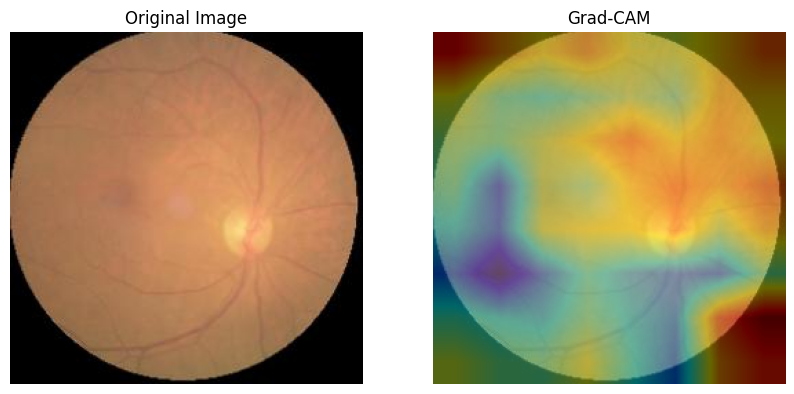

In [45]:
# Plot the original and Grad-CAM superimposed images
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM")
plt.axis('off')

plt.show()
